<a href="https://colab.research.google.com/github/rajalingam24/Emotion-Detection/blob/main/Approach1_Mobilenet_Emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
                                  

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/Colab file/fer2013.csv'

df = pd.read_csv(dataset_path)

df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

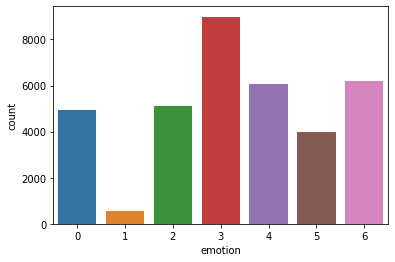

In [ ]:
import seaborn as sns
sns.countplot(data=df, x = 'emotion')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten,Dropout, MaxPooling2D, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


test_datagen = ImageDataGenerator()

In [ ]:
image_size=(48,48)

# Data Loading and Pre-Processing Functionalities

def load_dataset():
    data = pd.read_csv(dataset_path)
    data = (data[data['pixels'].notnull()])
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'),image_size)
        face = np.stack((face,)*3, -1)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    #faces = np.expand_dims(faces, -1)
    emotions = (data['emotion'])#.values
    return faces, emotions
 
def preprocess_data(x):
    x = x.astype('float32')
    x = x / 255.0
    return x

In [ ]:
#Data Augumentation
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        shear_range = 10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

faces, emotions = load_dataset()
faces = preprocess_data(faces)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)

In [ ]:
import tensorflow as tf

base_model=tf.keras.applications.MobileNet()

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [ ]:
base_model=tf.keras.applications.MobileNet(input_shape=(128,128,3),include_top=False)

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable=False
base_model.summary()

Model: "mobilenet_1.00_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 64, 64, 32) 

In [ ]:
transfer_model=Sequential([base_model,
                          GlobalAveragePooling2D(),
                          Dense(1024,activation='relu'),
                          Dense(512,activation='relu'),
                          Dense(128,activation='relu'),
                          Dense(7,activation='softmax')])

In [ ]:
transfer_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
from tensorflow.keras.utils import to_categorical
batch_size = 64
num_epochs = 100
history = transfer_model.fit(data_generator.flow(Xtrain, to_categorical(Ytrain)), 
                    steps_per_epoch = int (len(Xtrain) / batch_size), 
                    epochs = num_epochs, 
                    validation_data = test_datagen.flow(Xtest, to_categorical(Ytest)), 
                    validation_steps = int (len(Xtest) / batch_size)
                    )

Epoch 1/100
448/448 [==============================] - 44s 29ms/step - loss: 1.7473 - accuracy: 0.2979 - val_loss: 1.6804 - val_accuracy: 0.3354
Epoch 2/100
448/448 [==============================] - 13s 29ms/step - loss: 1.6938 - accuracy: 0.3267 - val_loss: 1.6687 - val_accuracy: 0.3393
Epoch 3/100
448/448 [==============================] - 13s 28ms/step - loss: 1.6826 - accuracy: 0.3313 - val_loss: 1.6527 - val_accuracy: 0.3616
Epoch 4/100
448/448 [==============================] - 13s 29ms/step - loss: 1.6725 - accuracy: 0.3364 - val_loss: 1.6552 - val_accuracy: 0.3477
Epoch 5/100
448/448 [==============================] - 13s 29ms/step - loss: 1.6646 - accuracy: 0.3384 - val_loss: 1.6465 - val_accuracy: 0.3488
Epoch 6/100
448/448 [==============================] - 13s 29ms/step - loss: 1.6550 - accuracy: 0.3428 - val_loss: 1.6552 - val_accuracy: 0.3583
Epoch 7/100
448/448 [==============================] - 13s 29ms/step - loss: 1.6413 - accuracy: 0.3493 - val_loss: 1.6610 - val_ac

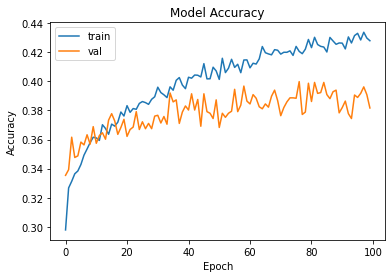

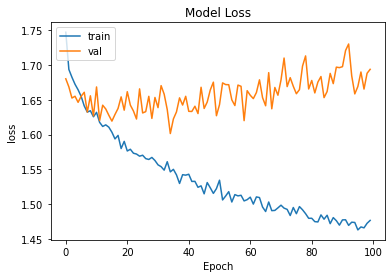

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pd.DataFrame(history.history).tail()

,loss,accuracy,val_loss,val_accuracy
95,1.462947,0.433036,1.669257,0.388951
96,1.467250,0.428472,1.690127,0.391741
97,1.465930,0.433783,1.665558,0.396205
98,1.472489,0.429799,1.688302,0.390904
99,1.476626,0.427944,1.693974,0.381696


In [ ]:
import cv2


In [ ]:
#img_array_expanded_dims = np.expand_dims(img_array, axis=0)
img_pp=tf.keras.applications.mobilenet.preprocess_input(Xtest)

In [ ]:
Xtrain.shape

(28709, 48, 48, 3)

In [ ]:
xt=[]
for i in range(len(Xtest)):
  xt.append(cv2.resize(Xtest[i],(128,128)))


In [ ]:
Xtest_mobi=np.array(xt)

In [ ]:
Xtest_mobi[0]

array([[[0.2235294 , 0.2235294 , 0.2235294 ],
        [0.2257353 , 0.2257353 , 0.2257353 ],
        [0.23897061, 0.23897061, 0.23897061],
        ...,
        [0.4105392 , 0.4105392 , 0.4105392 ],
        [0.41495097, 0.41495097, 0.41495097],
        [0.41568625, 0.41568625, 0.41568625]],

       [[0.22132353, 0.22132353, 0.22132353],
        [0.22336093, 0.22336093, 0.22336093],
        [0.2355852 , 0.2355852 , 0.2355852 ],
        ...,
        [0.41081494, 0.41081494, 0.41081494],
        [0.41541058, 0.41541058, 0.41541058],
        [0.4161765 , 0.4161765 , 0.4161765 ]],

       [[0.20808825, 0.20808825, 0.20808825],
        [0.20911458, 0.20911458, 0.20911458],
        [0.21527268, 0.21527268, 0.21527268],
        ...,
        [0.41246936, 0.41246936, 0.41246936],
        [0.4181679 , 0.4181679 , 0.4181679 ],
        [0.41911766, 0.41911766, 0.41911766]],

       ...,

       [[0.32034314, 0.32034314, 0.32034314],
        [0.3179841 , 0.3179841 , 0.3179841 ],
        [0.30382967, 0

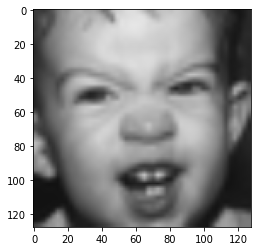

In [ ]:
plt.imshow(Xtest_mobi[5])

In [ ]:
#Xtest_mobi1=tf.keras.applications.mobilenet.preprocess_input(Xtest_mobi)

In [ ]:
pred=transfer_model.predict(Xtest_mobi)

In [ ]:
pred[0].argmax()

6

In [ ]:
ypred=[]
for i in range(len(pred)):
  ypred.append(pred[i].argmax())

In [ ]:
ypred=np.array(ypred)
np.unique(ypred)

array([2, 3, 4, 5, 6])

In [ ]:
Ytest.value_counts()

3    1807
4    1273
6    1210
2    1012
0     964
5     809
1     103
Name: emotion, dtype: int64

In [ ]:
ytest=np.array(Ytest)

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(ytest,ypred)
cm

array([[   0,    0,    5,    7,   21,   57,  874],
       [   0,    0,    0,    0,    3,    6,   94],
       [   0,    0,    9,   10,   41,  129,  823],
       [   0,    0,   13,   28,   37,  109, 1620],
       [   0,    0,    6,    6,   50,   58, 1153],
       [   0,    0,    5,    4,   43,  278,  479],
       [   0,    0,    8,    3,   42,   90, 1067]])

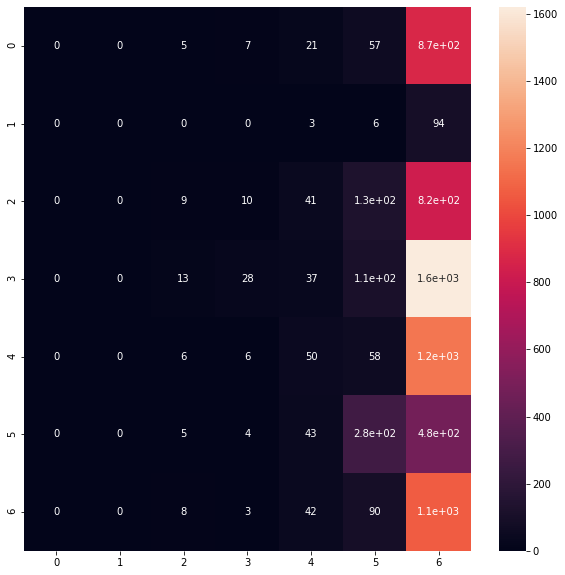

In [ ]:
import seaborn as sb
plt.figure(figsize=(10,10))
sb.heatmap(cm,annot=True)